In this IPython notebook, we will demonstrate how to enable the controller for the waterheater by playing the grid frequency to the simulator. To run this notebook, please make sure you are in a UNIX based environment and have all the necessary python packages installed.

In [1]:
!ls

controller_usage_demonstration.ipynb smSingle.glm
fan1.csv                             smSingle_base.glm
fan2.csv                             smSingle_lenient_freq.glm
frequency.PLAYER                     smSingle_strict_freq.glm
gridlabd_MAC.bin                     wh1_base.csv
hot_water_demand.glm                 wh1_lenient_freq.csv
local_gd                             wh1_strict_freq.csv


We need to re-configure the path for the gridlab-d we installed such that the binary can locate the path of the library

In [14]:
%%bash
oldpath='/Users/jingkungao/Documents/Software/gridlab-d/develop/7/local_gd'
newpath=`pwd`'/local_gd' 
sed -i "s#$oldpath#$newpath#" local_gd/bin/gridlabd
sed -i "s#$oldpath#$newpath#" local_gd/lib/gridlabd/glxengine.la

In [15]:
!local_gd/bin/gridlabd --version

GridLAB-D 4.0.0-17296 (feature/730:17296) 64-bit MACOSX RELEASE


The above listed **local_gd/bin/gridlabd** is the binary version of the gridlab-d software with controlling functionality. In addition to that, we have **.glm** files and generated **.csv** files. We also have a **frequency.PLAYER** containing the second level frequency information.

The version of the gridlab-d binary file and the content of the frequency.PLAYER can be seen below.

If the version of the gridlab-d does not work, we can disable the comments below and run the command to compile the source and install the gridlab-d to the machine.

In [16]:
'''
%%bash
cd ~
git clone -b feature/730 https://github.com/jingkungao/gridlab-d.git 
cd gridlab-d 
cd third_party 
chmod +x install_xercesc 
. install_xercesc 
tar -xvf cppunit-1.12.0.tar
cd cppunit-1.12.0
./configure LDFLAGS="-ldl"
make 
sudo make install
cd ../..
autoreconf -isf 
./configure 
make 
sudo make install
'''

'\n%%bash\ncd ~\ngit clone -b feature/730 https://github.com/jingkungao/gridlab-d.git \ncd gridlab-d \ncd third_party \nchmod +x install_xercesc \n. install_xercesc \ntar -xvf cppunit-1.12.0.tar\ncd cppunit-1.12.0\n./configure LDFLAGS="-ldl"\nmake \nsudo make install\ncd ../..\nautoreconf -isf \n./configure \nmake \nsudo make install\n'

In [17]:
!head frequency.PLAYER

We can further plot the frequency data to get some ideas.

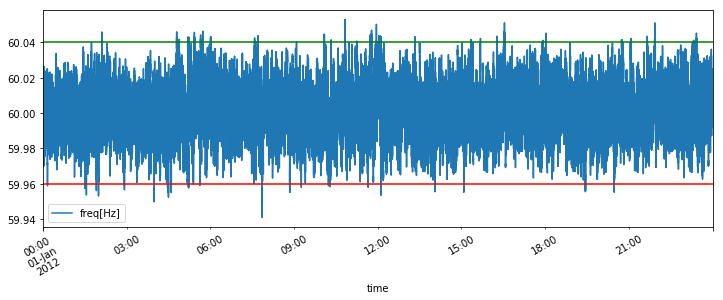

In [18]:
%matplotlib inline

import numpy as np
import pandas as pd

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

raw_freq = pd.read_csv('frequency.PLAYER',index_col=0,names=['time','freq[Hz]'],
                       parse_dates=True,infer_datetime_format=True)

freq_low = 59.96
freq_high = 60.04

ax = raw_freq.plot(figsize=(12,4),rot=30)
ax.axhline(y=freq_low, c='red')
ax.axhline(y=freq_high, c='green')

Next, we will run **gridlab.bin** on different **.glm** files and plot the outputs showing the difference with and without controllers.

We start with running **smSingle_base.glm**, which is almost same as the original **smSingle.glm** with the difference being changing the simulation clock and adding a recoreder for waterheater1 at the end.

# Base case
We change the simulation time to match with **frequency.PLAYER** and append the following lines to record the waterheater data. We record data for waterheater1 as an example. It could be used for any waterheater. We also set the timestep to 1 second instead of 60 seconds. Due to the existing water demand schedule *water14* is not realistic, we include a **hot_water_demand.glm** to show the weekday and weekend water demand usage patterns. 

In [19]:
# from 2012-01-01 to 2012-01-02
!head -9 smSingle_base.glm

clock {
	timezone PST+8PDT;
	starttime '2012-01-01 00:00:00';
	stoptime '2012-01-02 00:00:00';
};

#include "hot_water_demand.glm";

#set minimum_timestep=1;


In [20]:
# record data for waterheater1 at 1s resolution
!tail -8 smSingle_base.glm


object recorder {
	interval 1;
	property measured_frequency,temperature,actual_load,is_waterheater_on,water_demand;
		// current_tank_status,waterheater_model,heatgain,power_state;
	file wh1_base.csv;
	parent waterheater1;
};

In [21]:
# run the gridlabd.bin to start the simulation
!local_gd/bin/gridlabd smSingle_base.glm

WARNING  [INIT] : waterheater::init() : height and diameter were not specified, defaulting to 3.78 ft
                                      
Core profiler results

Total objects                 35 objects
Parallelism                    1 thread
Total time                  33.0 seconds
  Core time                  2.7 seconds (8.3%)
    Compiler                 3.0 seconds (9.0%)
    Instances                0.0 seconds (0.0%)
    Random variables         0.0 seconds (0.0%)
    Schedules                0.0 seconds (0.0%)
    Loadshapes               0.1 seconds (0.2%)
    Enduses                  0.0 seconds (0.1%)
    Transforms               0.3 seconds (0.9%)
  Model time                30.3 seconds/thread (91.7%)
Simulation time                1 days
Simulation speed              25 object.hours/second
Passes completed           86401 passes
Time steps completed       86401 timesteps
Convergence efficiency      1.00 passes/timestep
Read lock contention        0.0%
Write lock content

Now, we plot the generated waterheater data stored in **wh1_base.csv** from the simulation.

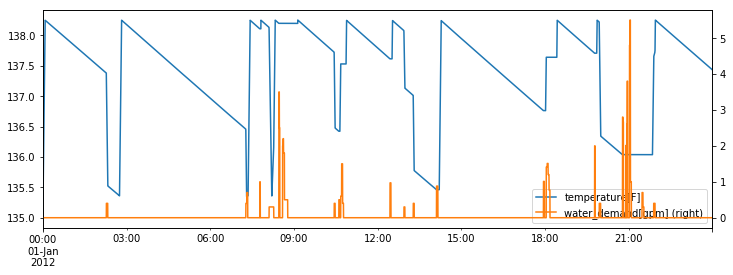

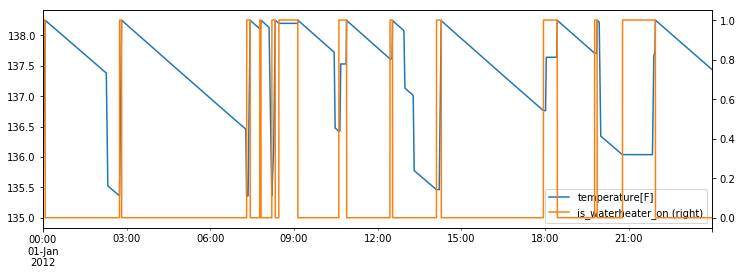

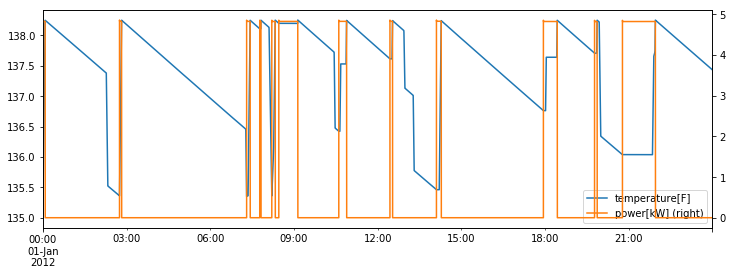

In [22]:
df_base = pd.read_csv('wh1_base.csv',sep=',',header=8,
                 index_col=0,parse_dates=True,infer_datetime_format=True,
                 names=['freq[Hz]','temperature[F]','power[kW]','is_waterheater_on',
                         'water_demand[gpm]'])

df_base[['temperature[F]', 'water_demand[gpm]']].plot(figsize=(12,4),
                                                  secondary_y='water_demand[gpm]')

df_base[['temperature[F]','is_waterheater_on']].plot(figsize=(12,4),
                                                 secondary_y='is_waterheater_on')

df_base[['temperature[F]','power[kW]']].plot(figsize=(12,4),
                                                 secondary_y='power[kW]')

In [23]:
# We can also plot the interactive version of the plot during certain period
def plotly_plotdf(df,title='Interactive plot of column variables'):
    if len(df)>20000:
        print('Too many points, please reduce number of points! (less than 20000)')
        return
    data = []
    for i in df.columns:
        trace = go.Scatter(
            name = i,
            x = df.index,
            y = df[i]
        )
        data.append(trace)
    fig = go.Figure(
        data = data,
        layout = go.Layout(showlegend=True,
                          title=title)
    )
    iplot(fig)

In [24]:
# we can toggle the varialbe to visualize each of them
plotly_plotdf(df_base.resample('1min').mean())

# Lenient Frequency Control 
We modify waterheater 1 to enable the frequency control, but we have a very wide frequency band (59.9Hz - 60.1Hz). In other words, the gridballast controller is rarely triggered. 

In [ ]:
!head -611 smSingle_lenient_freq.glm|tail -21

object waterheater {
	schedule_skew -810;
	water_demand weekday_hotwater*1;
	name waterheater1;
	parent house1;
	heating_element_capacity 4.8 kW;
	thermostat_deadband 2.9;
	location INSIDE;
	tank_volume 50;
	tank_setpoint 136.8;
	tank_UA 2.4;
	temperature 135;
	object player {
		file frequency.PLAYER;
		property measured_frequency;
    };
	enable_freq_control true;
	freq_lowlimit 59.9;
	freq_uplimit 60.1;
	heat_mode ELECTRIC;
};


In [ ]:
# run the gridlabd.bin to start the simulation
!local_gd/bin/gridlabd smSingle_lenient_freq.glm

WARNING  [INIT] : waterheater::init() : height and diameter were not specified, defaulting to 3.78 ft


Now, we plot the generated waterheater data stored in **wh1_lenient_freq.csv** from the simulation.

In [ ]:
# We save data to wh1_lenient_freq.csv and plot the results
df_lenient_freq = pd.read_csv('wh1_lenient_freq.csv',sep=',',header=8,
                 index_col=0,parse_dates=True,infer_datetime_format=True,
                 names=['freq[Hz]','temperature[F]','power[kW]','is_waterheater_on',
                         'water_demand[gpm]'])

df_lenient_freq[['temperature[F]', 'water_demand[gpm]']].plot(figsize=(12,4),
                                                  secondary_y='water_demand[gpm]')

df_lenient_freq[['temperature[F]','is_waterheater_on']].plot(figsize=(12,4),
                                                 secondary_y='is_waterheater_on')

df_lenient_freq[['temperature[F]','power[kW]']].plot(figsize=(12,4),
                                                 secondary_y='power[kW]')

In [ ]:
# we can toggle the varialbe to visualize others
plotly_plotdf(df_lenient_freq.resample('1min').mean())

# Strict Frequency Control 
We modify waterheater 1 to enable the frequency control, but we have a very tight frequency band (59.97Hz - 60.03Hz). In other words, the gridballast controller is triggered very often. 

In [ ]:
!head -611 smSingle_strict_freq.glm|tail -21

In [ ]:
# run the gridlabd.bin to start the simulation
!local_gd/bin/gridlabd smSingle_strict_freq.glm

Now, we plot the generated waterheater data stored in **wh1_strict_freq.csv** from the simulation.

In [ ]:
# We save data to wh1_lenient_freq.csv and plot the results
df_strict_freq = pd.read_csv('wh1_strict_freq.csv',sep=',',header=8,
                 index_col=0,parse_dates=True,infer_datetime_format=True,
                 names=['freq[Hz]','temperature[F]','power[kW]','is_waterheater_on',
                         'water_demand[gpm]'])

df_strict_freq[['temperature[F]', 'water_demand[gpm]']].plot(figsize=(12,4),
                                                  secondary_y='water_demand[gpm]')

df_strict_freq[['temperature[F]','is_waterheater_on']].plot(figsize=(12,4),
                                                 secondary_y='is_waterheater_on')

df_strict_freq[['temperature[F]','power[kW]']].plot(figsize=(12,4),
                                                 secondary_y='power[kW]')

In [ ]:
# we can toggle the varialbe to visualize others
plotly_plotdf(df_strict_freq.resample('1min').mean())

In [ ]:
# we can plot the frequency and the lower/upper limit again
freq_low = 59.97
freq_high = 60.03

ax = raw_freq.plot(figsize=(12,4),rot=30)
ax.axhline(y=freq_low, c='red')
ax.axhline(y=freq_high, c='green')